<a href="https://colab.research.google.com/github/angie-cris/angie-cris/blob/main/Asignaci%C3%B3nRegresi%C3%B3nLineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federico Quiroga y Angie Cristancho

`Modelo de regresión lineal simple con transformaciones y selección de variables.`

1600 zonas ordenadas contiguamente. Objetivo: pronostico de ventas de ropa para mujer en millones de pesos para el año.
Usar prediccion sobre 400 zonas en el archivo train.
Evaluacion: RMSE.

## Librerías

In [ ]:
install.packages("corrplot")
install.packages("lmtest")
install.packages("MASS")
install.packages("leaps")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(corrplot)
library(lmtest)
library(MASS)
library(leaps)
library(readxl)

## Preparación de Datos

In [ ]:
datos <- read_excel("datos.xlsx")
str(datos)
#tenemos que dropear los id_ incluyendo idloc e idmercado, revisar los missing

tibble [1,600 × 12] (S3: tbl_df/tbl/data.frame)
 $ idloc    : num [1:1600] 1648 1259 674 1558 1626 ...
 $ edadloc  : num [1:1600] 11 3 13 7 22 8 22 8 4 4 ...
 $ correo   : num [1:1600] 10042 11909 10669 6981 10940 ...
 $ paginas  : num [1:1600] 68 107 75 65 74 110 73 106 84 112 ...
 $ telefono : num [1:1600] 35 42 33 19 37 55 34 45 39 46 ...
 $ impresa  : num [1:1600] 22609 24562 38914 39205 23947 ...
 $ servicio : num [1:1600] 30 35 52 30 46 57 50 41 25 39 ...
 $ nomina   : num [1:1600] 66307 29107 9519 28651 30654 ...
 $ idmercado: num [1:1600] 8 8 4 7 7 7 8 3 7 9 ...
 $ tamamer  : chr [1:1600] "Grande" "Grande" "Median" "Grande" ...
 $ promo    : num [1:1600] 2 2 3 1 2 1 3 1 2 1 ...
 $ ropamujer: num [1:1600] 43748 37484 57523 50338 45676 ...


In [ ]:
datos <- datos [-c(1, 9)]
str(datos)

tibble [1,600 × 10] (S3: tbl_df/tbl/data.frame)
 $ edadloc  : num [1:1600] 11 3 13 7 22 8 22 8 4 4 ...
 $ correo   : num [1:1600] 10042 11909 10669 6981 10940 ...
 $ paginas  : num [1:1600] 68 107 75 65 74 110 73 106 84 112 ...
 $ telefono : num [1:1600] 35 42 33 19 37 55 34 45 39 46 ...
 $ impresa  : num [1:1600] 22609 24562 38914 39205 23947 ...
 $ servicio : num [1:1600] 30 35 52 30 46 57 50 41 25 39 ...
 $ nomina   : num [1:1600] 66307 29107 9519 28651 30654 ...
 $ tamamer  : chr [1:1600] "Grande" "Grande" "Median" "Grande" ...
 $ promo    : num [1:1600] 2 2 3 1 2 1 3 1 2 1 ...
 $ ropamujer: num [1:1600] 43748 37484 57523 50338 45676 ...


In [ ]:
colSums(is.na(datos)) #no hay n.a.'s
#el valor de tamamer  es una categoría y hay que hacer one hot encoding
#la categoría de tamamer tiene que ser codificacada para ser procesada

edadloc    correo   paginas  telefono   impresa  servicio    nomina   tamamer 
        0         0         0         0         0         0         0         0 
    promo ropamujer 
        0         0

In [ ]:
unique(datos$tamamer)

[1] "Grande"  "Median"  "Pequeño"

In [ ]:
#debido a que no tenemos que usar nada que reciba unicamente números
#y dado que R hace la codificación de factores como categorías
# a menos que yo establezca el orden como el siguiente en tamamer
datos$tamamer <- factor(datos$tamamer,
                        levels = c("Pequeño", "Median", "Grande"),
                        ordered = TRUE)
datos$promo <- factor(datos$promo)
str(datos)

tibble [1,600 × 10] (S3: tbl_df/tbl/data.frame)
 $ edadloc  : num [1:1600] 11 3 13 7 22 8 22 8 4 4 ...
 $ correo   : num [1:1600] 10042 11909 10669 6981 10940 ...
 $ paginas  : num [1:1600] 68 107 75 65 74 110 73 106 84 112 ...
 $ telefono : num [1:1600] 35 42 33 19 37 55 34 45 39 46 ...
 $ impresa  : num [1:1600] 22609 24562 38914 39205 23947 ...
 $ servicio : num [1:1600] 30 35 52 30 46 57 50 41 25 39 ...
 $ nomina   : num [1:1600] 66307 29107 9519 28651 30654 ...
 $ tamamer  : Ord.factor w/ 3 levels "Pequeño"<"Median"<..: 3 3 2 3 3 2 2 2 3 3 ...
 $ promo    : Factor w/ 3 levels "1","2","3": 2 2 3 1 2 1 3 1 2 1 ...
 $ ropamujer: num [1:1600] 43748 37484 57523 50338 45676 ...


In [ ]:
#aqui leer los datos de entrenamiento y prueba
test <-read.csv("test.csv")
train <- read.csv("train.csv")
str(train)

'data.frame':	1600 obs. of  12 variables:
 $ idloc    : int  1648 1259 674 1558 1626 939 176 782 163 1703 ...
 $ edadloc  : int  11 3 13 7 22 8 22 8 4 4 ...
 $ correo   : int  10042 11909 10669 6981 10940 12689 9773 13018 9546 13050 ...
 $ paginas  : int  68 107 75 65 74 110 73 106 84 112 ...
 $ telefono : int  35 42 33 19 37 55 34 45 39 46 ...
 $ impresa  : num  22609 24562 38914 39205 23947 ...
 $ servicio : int  30 35 52 30 46 57 50 41 25 39 ...
 $ nomina   : int  66307 29107 9519 28651 30654 30528 27890 11107 111305 34739 ...
 $ idmercado: int  8 8 4 7 7 7 8 3 7 9 ...
 $ tamamer  : chr  "Grande" "Grande" "Median" "Grande" ...
 $ promo    : int  2 2 3 1 2 1 3 1 2 1 ...
 $ ropamujer: num  43748 37484 57523 50338 45676 ...


In [ ]:
train$tamamer <- factor(train$tamamer,
                        levels = c("Pequeño", "Median", "Grande"),
                        ordered = TRUE)
test$tamamer <- factor(test$tamamer,
                        levels = c("Pequeño", "Median", "Grande"),
                        ordered = TRUE)
train$promo <- factor(train$promo)
test$promo <- factor(test$promo)

Tenemos que predecir cuántas venta.

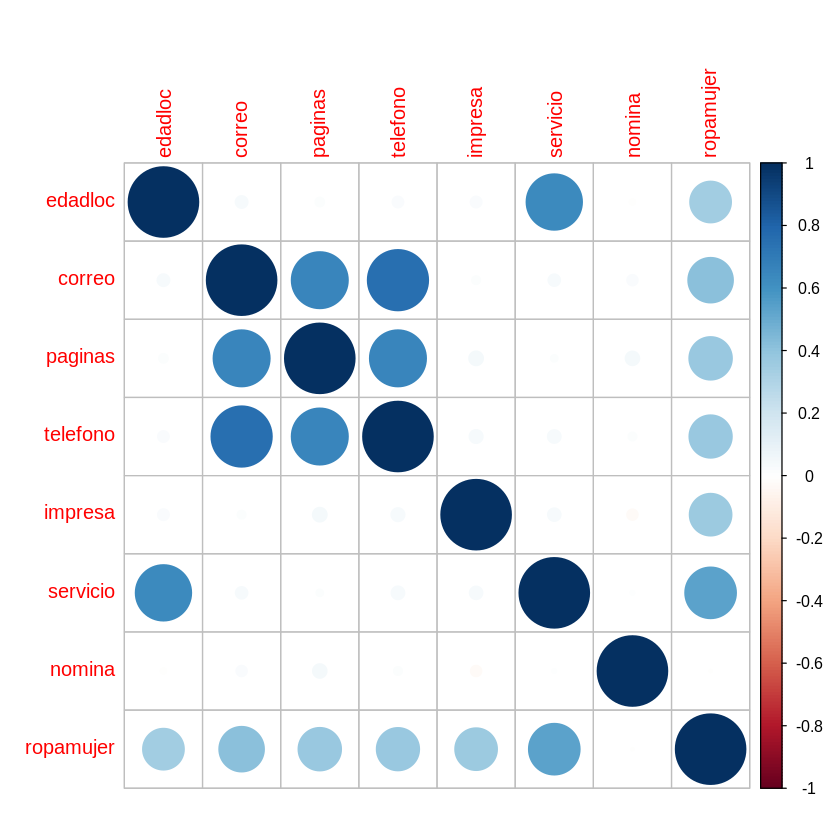

In [ ]:
matrizcor <- cor(datos[sapply(datos, is.numeric)])
corrplot(matrizcor)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


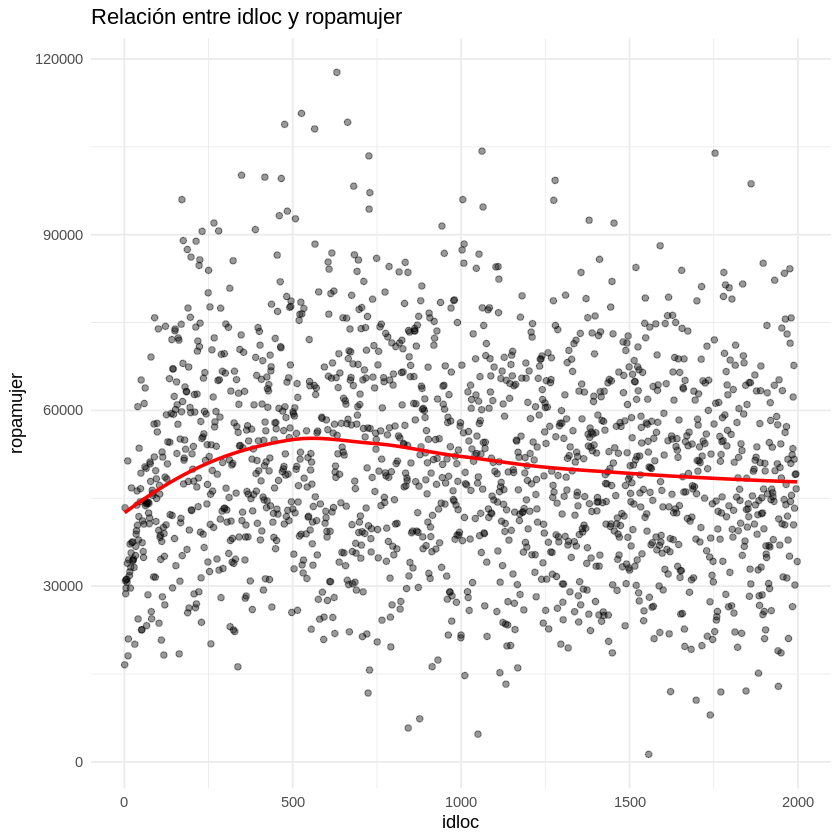

`geom_smooth()` using formula = 'y ~ x'


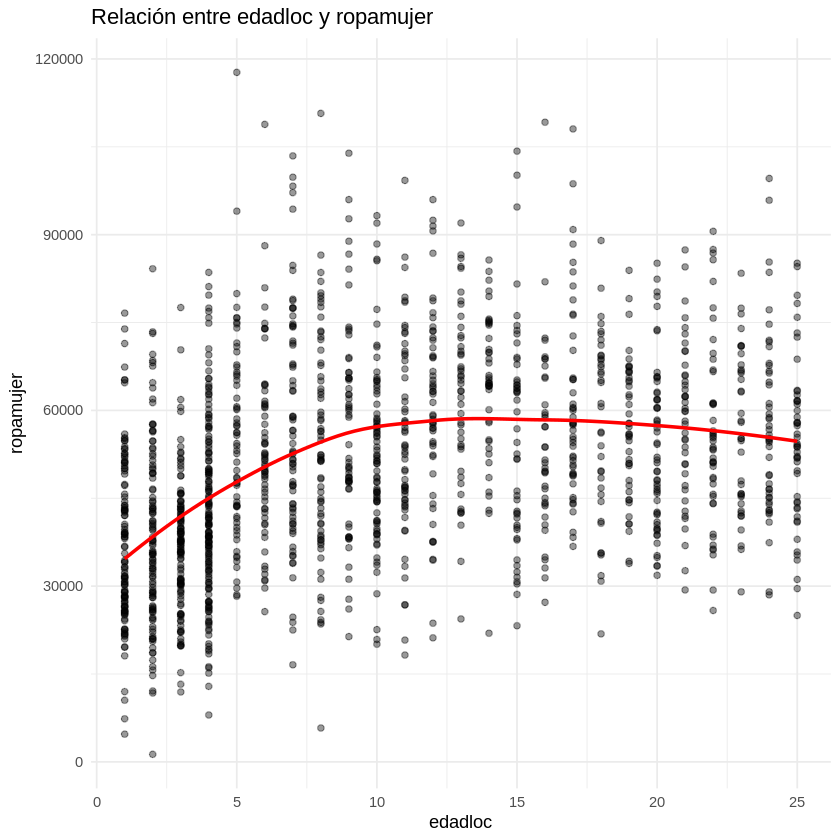

`geom_smooth()` using formula = 'y ~ x'


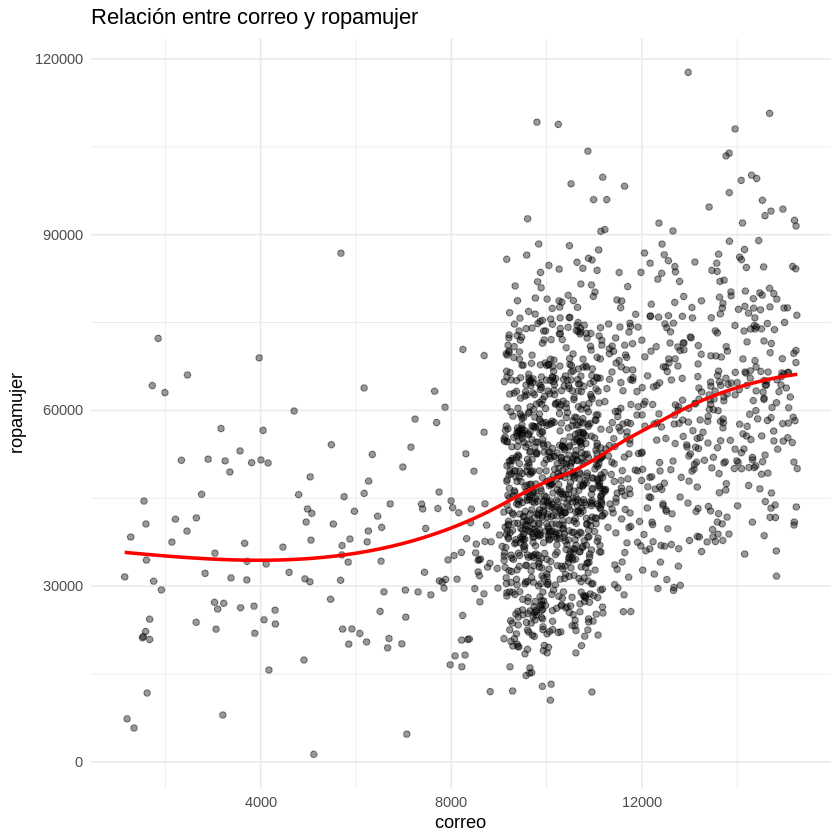

`geom_smooth()` using formula = 'y ~ x'


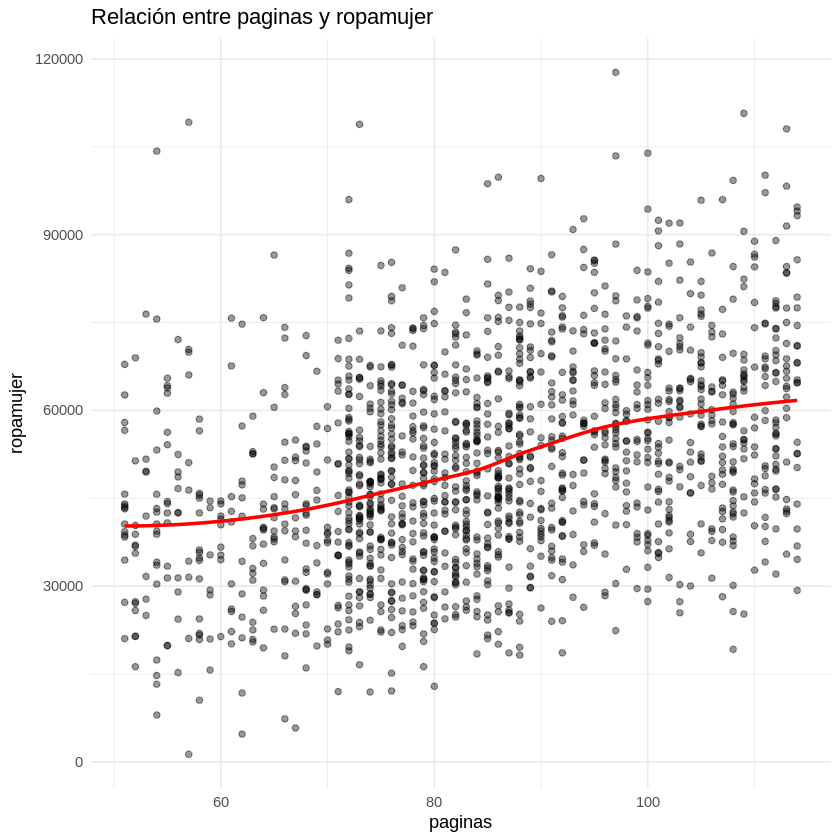

`geom_smooth()` using formula = 'y ~ x'


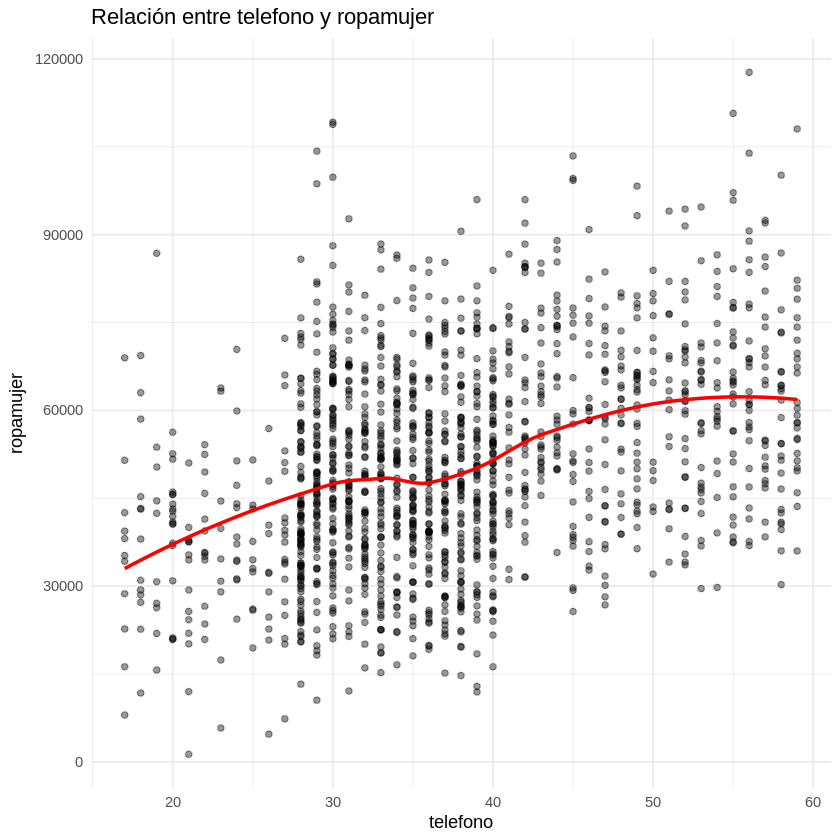

`geom_smooth()` using formula = 'y ~ x'


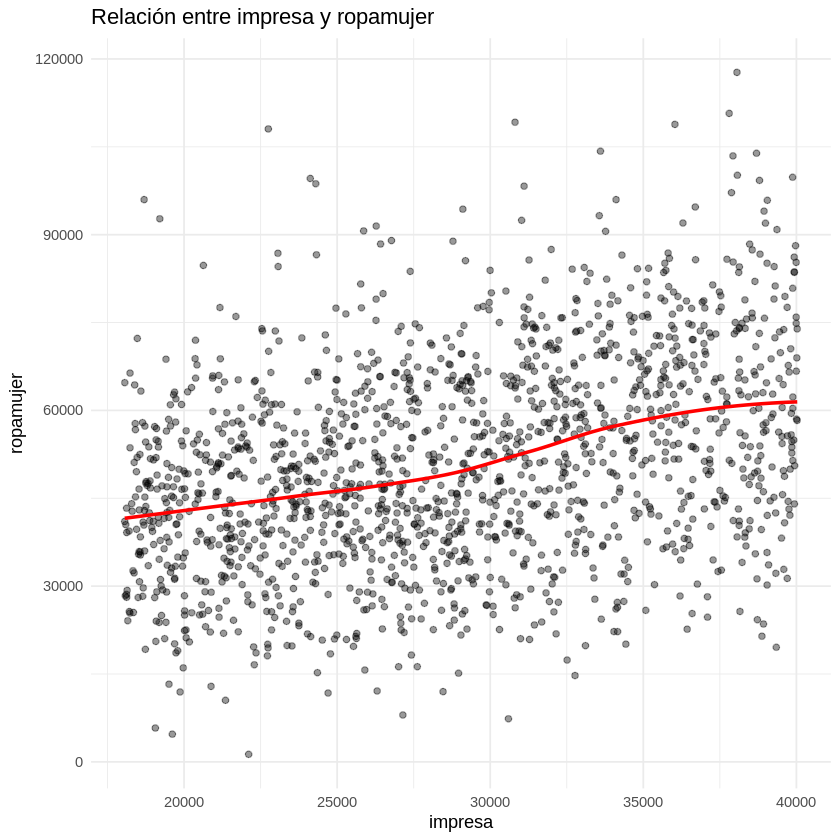

`geom_smooth()` using formula = 'y ~ x'


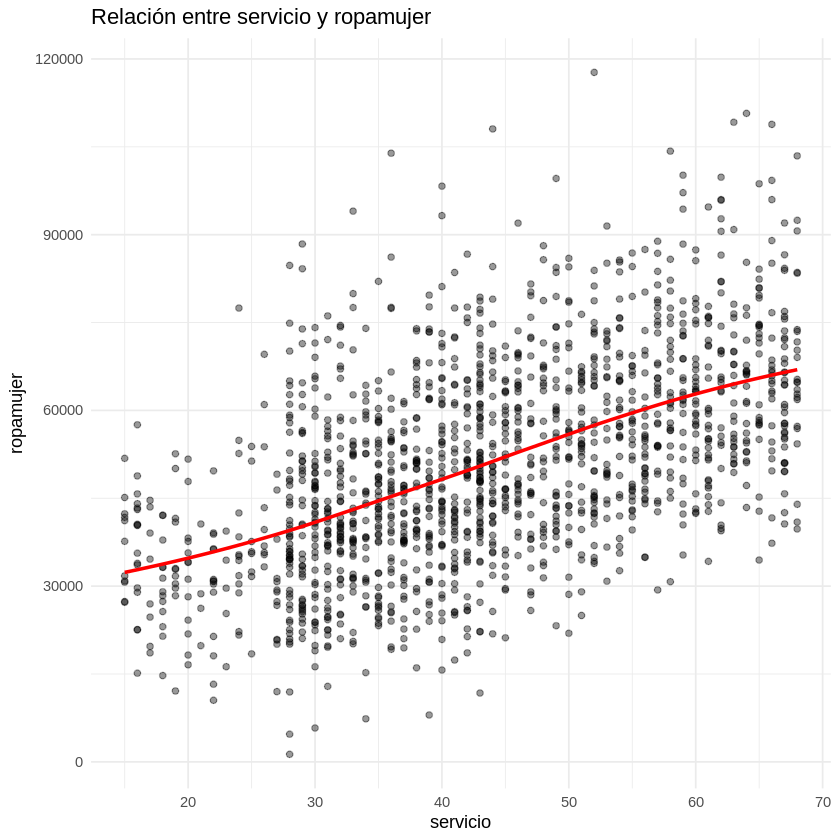

`geom_smooth()` using formula = 'y ~ x'


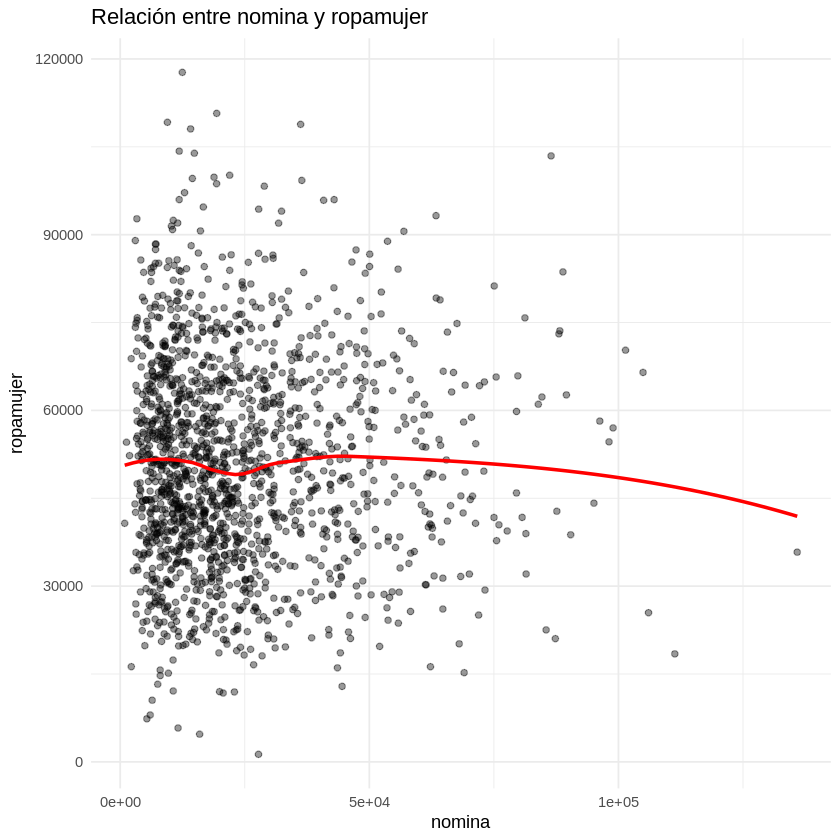

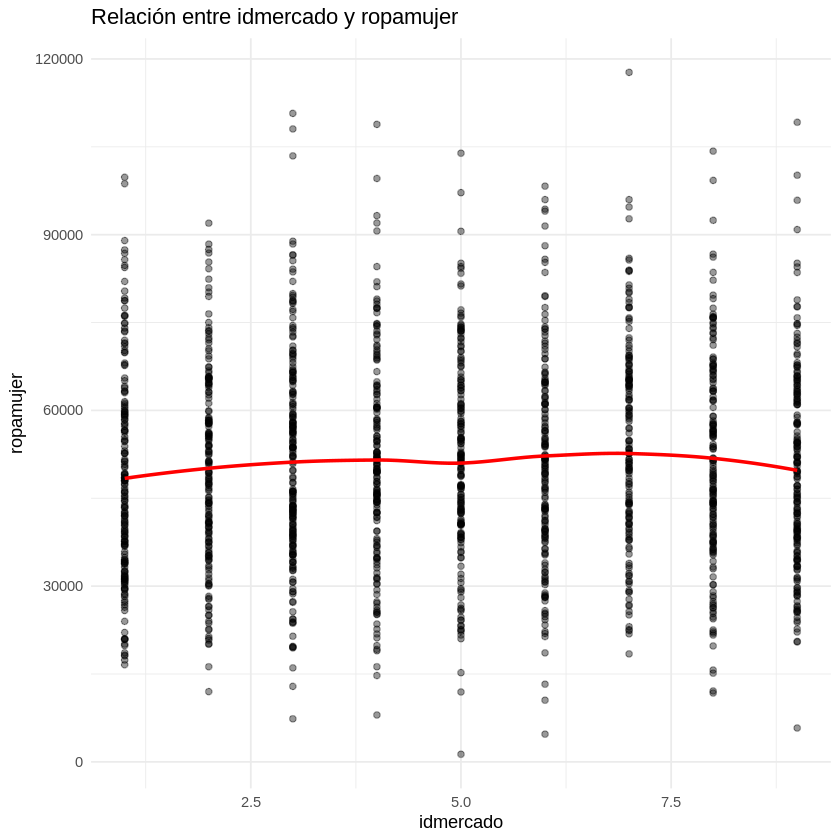

In [ ]:
library(ggplot2)

# Selecciona solo las variables numéricas
num_vars <- names(train)[sapply(train, is.numeric)]
num_vars <- setdiff(num_vars, "ropamujer")

# Gráficos dispersión y tendencia suave
for (v in num_vars) {
  p <- ggplot(train, aes_string(x = v, y = "ropamujer")) +
    geom_point(alpha = 0.4) +
    geom_smooth(method = "loess", se = FALSE, color = "red") +
    theme_minimal() +
    ggtitle(paste("Relación entre", v, "y ropamujer"))
  print(p)
}

La matriz de correlación evidencia la posible participación de todas las variables excepto nomina en la predicción del valor de ropamujer. Sin embargo, una interferencia de colinealidad podría ser la relación entre servicio y edadloc o la de telefono y correo.

In [ ]:
#CREANDO MODELOS BÁSICOS
# un modelo con todas las variables (preespecificado)
modelo0<- lm(ropamujer ~.,data=train)

In [ ]:
summary(modelo0)


Call:
lm(formula = ropamujer ~ ., data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-32099  -7873   -656   7147  53318 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.098e+04  2.412e+03 -16.991  < 2e-16 ***
idloc       -3.037e+00  4.953e-01  -6.131 1.10e-09 ***
edadloc      6.892e+00  4.974e+01   0.139   0.8898    
correo       1.869e+00  1.888e-01   9.897  < 2e-16 ***
paginas      1.815e+02  2.476e+01   7.330 3.66e-13 ***
telefono     8.332e+01  4.656e+01   1.789   0.0737 .  
impresa      9.370e-01  4.533e-02  20.672  < 2e-16 ***
servicio     6.831e+02  2.779e+01  24.582  < 2e-16 ***
nomina      -1.803e-03  2.302e-02  -0.078   0.9376    
idmercado   -6.768e+00  1.091e+02  -0.062   0.9506    
tamamer.L   -3.800e+02  7.669e+02  -0.496   0.6203    
tamamer.Q    8.869e+01  4.961e+02   0.179   0.8581    
promo2      -5.863e+02  7.267e+02  -0.807   0.4199    
promo3       1.383e+02  8.773e+02   0.158   0.8747    
---
Signif. codes:  0 ‘***’

El modelo0 (con todas las variables) presenta la relevancia de cada variable en la predicción de ropamujer. Es evidente que se puede optar por quitar las variables que no cumplan con la prueba t y probar otro modelo.

In [ ]:
#un modelo con variables elegidas (preespecificado)
modelo1<- lm(ropamujer ~ impresa + servicio + correo + paginas, data=train)

In [ ]:
summary(modelo1)


Call:
lm(formula = ropamujer ~ impresa + servicio + correo + paginas, 
    data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-32111  -8018   -693   7131  55161 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.385e+04  2.204e+03 -19.897  < 2e-16 ***
impresa      9.382e-01  4.573e-02  20.515  < 2e-16 ***
servicio     6.787e+02  2.158e+01  31.451  < 2e-16 ***
correo       2.052e+00  1.568e-01  13.086  < 2e-16 ***
paginas      1.929e+02  2.363e+01   8.164 6.49e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11410 on 1595 degrees of freedom
Multiple R-squared:  0.5786,	Adjusted R-squared:  0.5776 
F-statistic: 547.6 on 4 and 1595 DF,  p-value: < 2.2e-16


In [ ]:
modelo2 <- lm(ropamujer ~ correo + edadloc + I(edadloc^2) +
                            impresa  + servicio + telefono + log(paginas),
              data = train)
summary(modelo2) #el mejor hasta ahora



Call:
lm(formula = ropamujer ~ correo + edadloc + I(edadloc^2) + impresa + 
    servicio + telefono + log(paginas), data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-33264  -7569   -521   6861  52065 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -9.231e+04  7.608e+03 -12.133  < 2e-16 ***
correo        1.920e+00  1.822e-01  10.536  < 2e-16 ***
edadloc       2.030e+03  1.592e+02  12.754  < 2e-16 ***
I(edadloc^2) -7.958e+01  5.981e+00 -13.306  < 2e-16 ***
impresa       9.370e-01  4.346e-02  21.561  < 2e-16 ***
servicio      6.029e+02  2.710e+01  22.244  < 2e-16 ***
telefono      1.100e+02  4.435e+01   2.480   0.0133 *  
log(paginas)  1.294e+04  1.928e+03   6.714 2.62e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10840 on 1592 degrees of freedom
Multiple R-squared:  0.6204,	Adjusted R-squared:  0.6188 
F-statistic: 371.7 on 7 and 1592 DF,  p-value: < 2.2e-16


In [ ]:
#Código para generar respuesta de kaggle
pred <- predict(modelo2, newdata = test)
submission <- data.frame(
  idloc = test$idloc,   # usa la columna de idloc del test
  ropamujer = pred      # tus predicciones
)
write.csv(submission, "submission.csv", row.names = FALSE)